# Load and test pre-trained models

Load and test Tb + Emiss models and check the metrics for all IGBP landcover classes separatelly.



In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import CenteredNorm
from tensorflow.keras.models import load_model

import xarray as xr
import pandas as pd
import numpy as np
import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess, telsem_datacube, doy2month_mapping
from src.model import plot_history, xy_split

models_path = "../../models/"
igbp_path = "../../data/processed/"

# Select ascending (0) or descending (1) pass
swath = 0

In [2]:
# Load a model
# datestring = "WSMv2_D_2024_06_28T184126"
datestring = "WSMv2_A_2024_06_28T184738"
model_path = os.path.join(models_path, datestring + ".keras")
history_path = os.path.join(models_path, datestring + "_history")

model = load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 60)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,995 (35.14 KB)

 Trainable params: 2,991 (11.68 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 5,984 (23.38 KB)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K²])'>,
        <Axes: title={'center': 'Epochs after loss < 20'}, xlabel='Epoch', ylabel='mse [K²]'>],
       dtype=object))

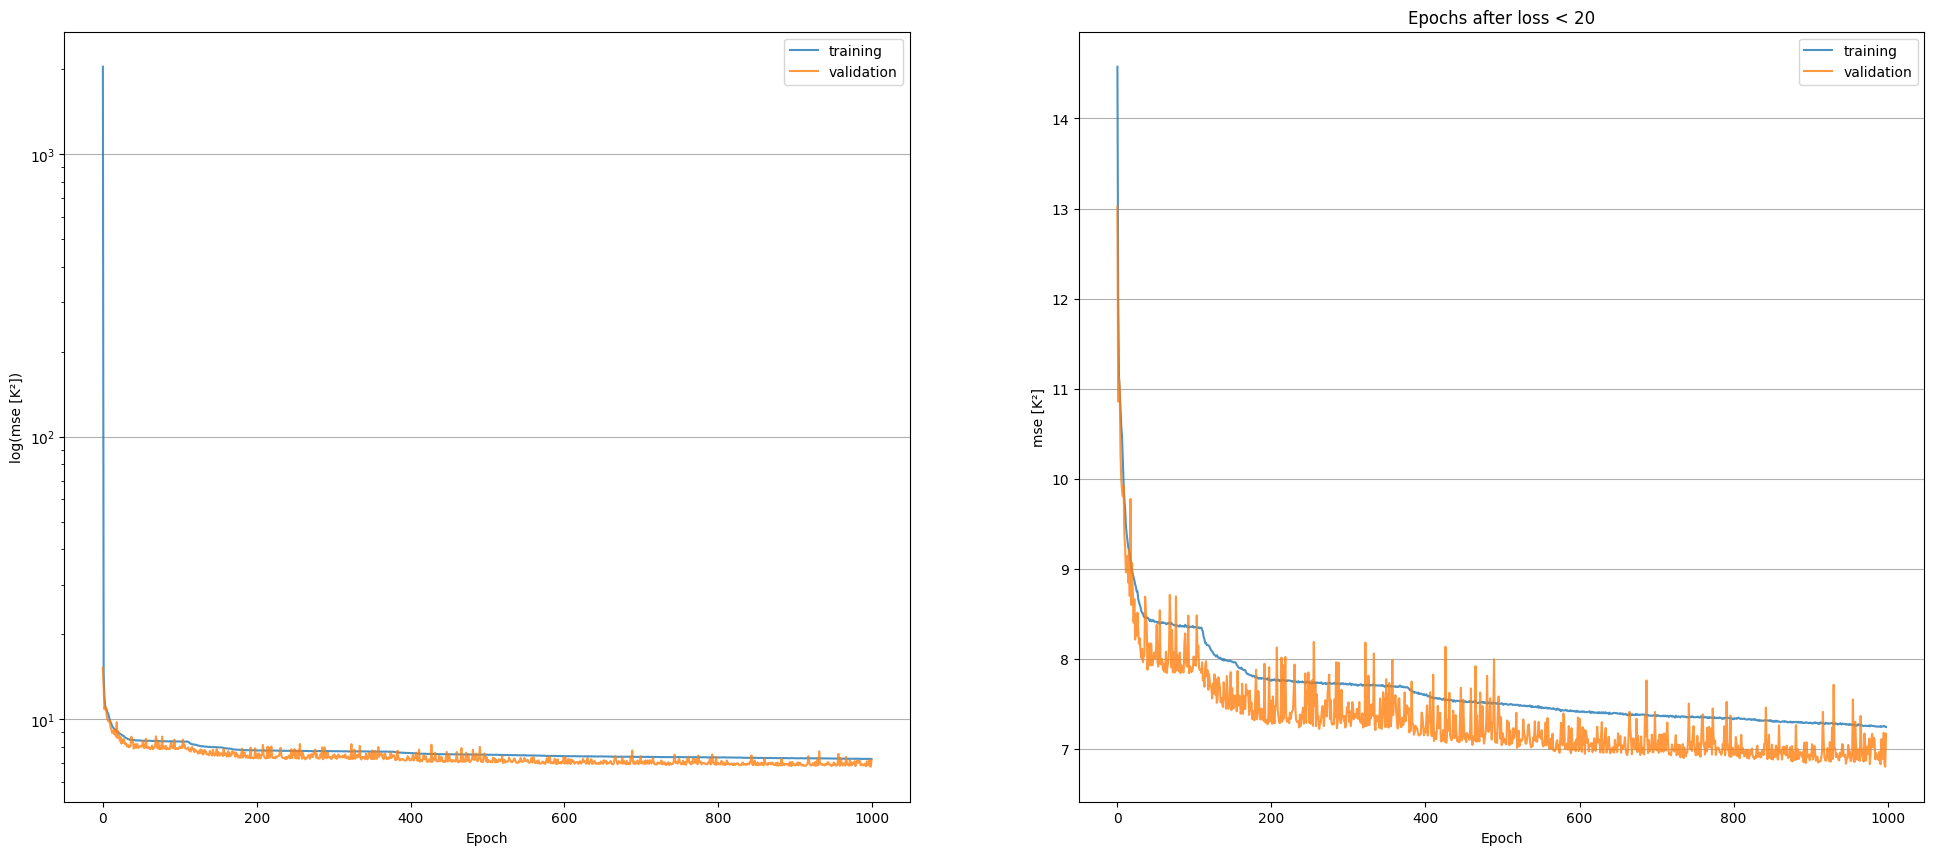

In [3]:
# Training history
with open(history_path, "rb") as file:
    history = pickle.load(file)

plot_history(history, loss_threshold = 20)

In [4]:
#TELSEM ATLAS
telsem_folder = r"..\..\data\processed\WindsatEmiss"

# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)

telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")


In [5]:
# WINDSAT data
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path, look=None)
swath_sd= model_preprocess(ds, swath_sector=swath)

# Select the variables from windsat that we need:
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

swath_sd = swath_sd[d_vars]

swath_df = swath_sd.to_dataframe().dropna().reset_index("day_number")

day_mapping = doy2month_mapping()

swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")

# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,0.646831,0.384178,0.728075,0.499101
1,286.504700,-52.125,299.625,226.136017,181.116562,237.195679,199.574356,0.766709,0.595761,0.818902,0.673376
2,285.798737,-52.125,300.375,226.611542,180.978912,238.014069,199.999802,0.810449,0.670419,0.834964,0.702682
3,285.345428,-51.875,300.125,239.678406,204.687469,248.563171,220.121918,0.793805,0.642822,0.817769,0.671116
4,285.551025,-51.875,300.625,240.952301,208.183792,249.369049,221.831299,0.800585,0.656406,0.816299,0.671582
...,...,...,...,...,...,...,...,...,...,...,...
1675637,279.382294,70.625,22.125,198.187500,130.512497,208.532501,153.035004,0.669632,0.419112,0.707013,0.448490
1675638,279.180969,70.625,22.375,204.407501,142.735001,210.417496,160.252502,0.670714,0.420704,0.707621,0.449943
1675639,278.574554,70.625,22.625,208.712494,151.412506,212.059998,165.992493,0.671796,0.422296,0.708228,0.451395
1675640,276.485809,70.625,22.875,210.847504,155.565002,212.977493,169.082489,0.672878,0.423889,0.708836,0.452847


In [6]:
# For the majority of models, lat lon are tranformed as folows: 
""" lat = sin(lat), lon = sin(lon)"""

# Save the original lat lon for plotting later
lat = combined_df["lat"].copy()
lon = combined_df["lon"].copy()

combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

In [7]:
# Predict for the local sample and plot:
X, y = xy_split(combined_df, y_column = "surtep_ERA5")
combined_df["surtep_MODEL"] = model.predict(X)
combined_df["error"] = combined_df["surtep_ERA5"] - combined_df["surtep_MODEL"]

52364/52364 ━━━━━━━━━━━━━━━━━━━━ 39s 745us/step


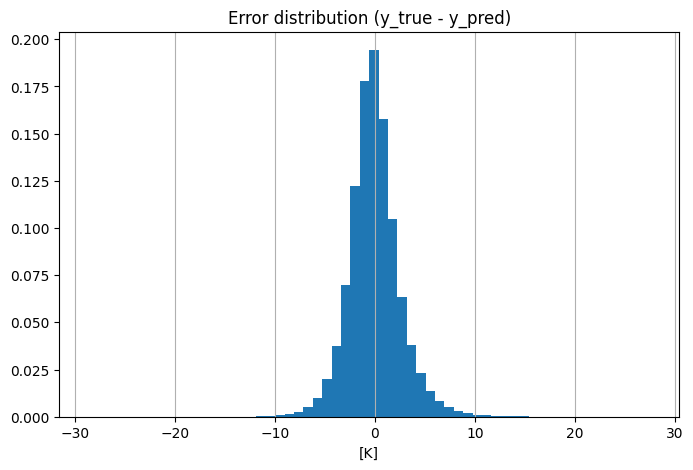

In [8]:
# Error histogram:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = combined_df["error"],
    density = True, bins = 60
)
ax.grid(axis="x")
ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
plt.show()

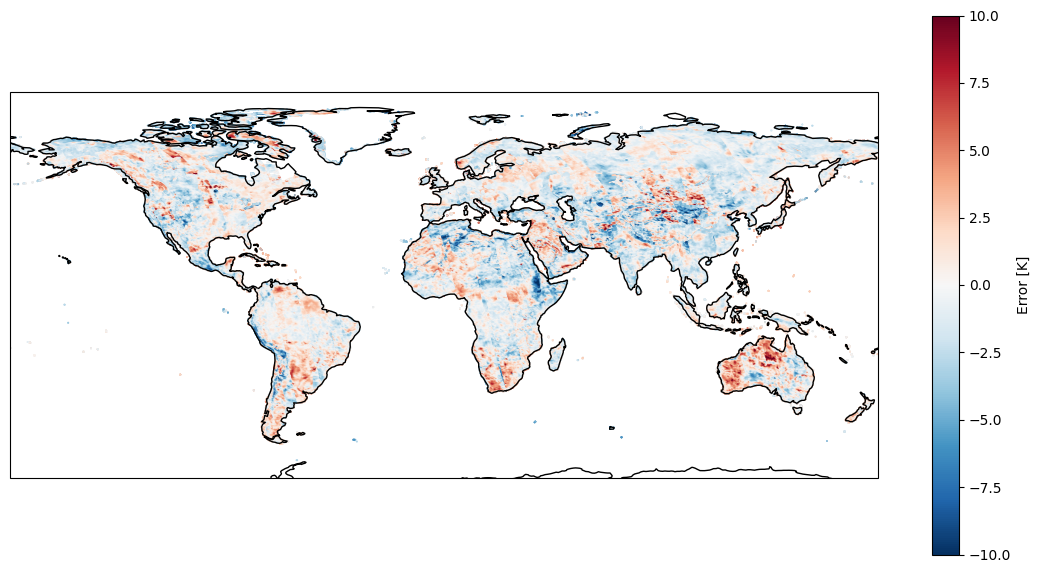

In [9]:
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = CenteredNorm(vcenter=0,halfrange=10, clip = False)

scatter = ax.scatter(
    x = lon,
    y = lat,
    s= 0.1,
    alpha = 1,
    c = combined_df["error"],
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Error [K]')
plt.show()


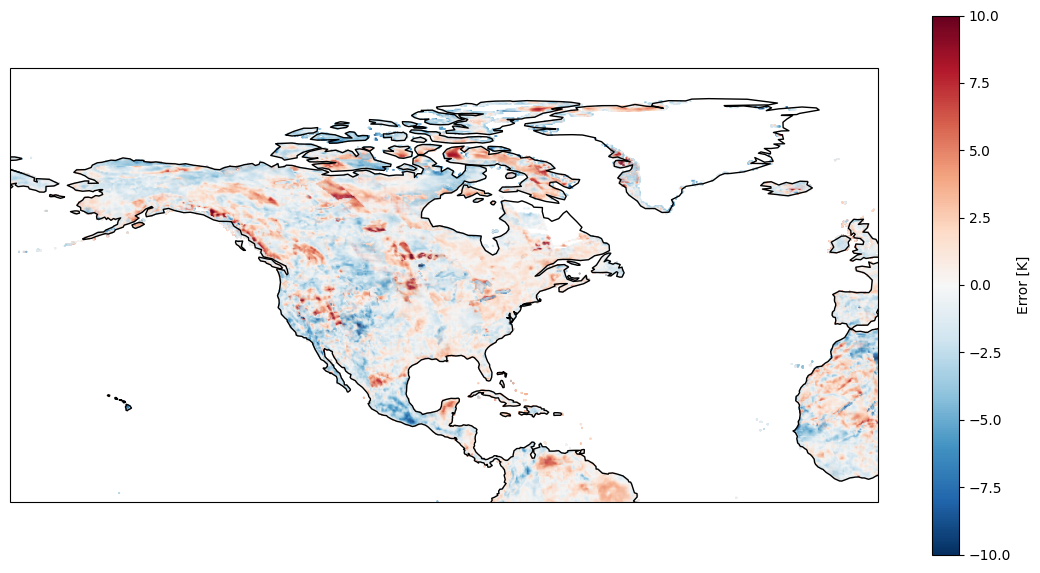

In [10]:
selected_area = [(0,90),(-180,0)]

ax.set_ylim(selected_area[0])
ax.set_xlim(selected_area[1])

fig

In [11]:
# Variable importance
# This gives us an idea on how much the model is relying on each variable for prediction.

from sklearn.inspection import permutation_importance
results = permutation_importance(
    model, X, y,
    scoring="neg_median_absolute_error",
    max_samples= 0.1, # We have a lot of data, use only 10 % 
    n_repeats=3
)


52364/52364 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 967us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 949us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 917us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 988us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 997us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 978us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 993us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 964us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 966us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 946us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
# Show results
importance = results.importances_mean
for i, v in enumerate(importance):
    print(f"Feature: {X.columns[i]}, score: {v:.5f}")

Feature: lat, score: 0.90287
Feature: lon, score: 0.10573
Feature: tbtoa_18Ghz_V, score: 5.84032
Feature: tbtoa_18Ghz_H, score: 2.83879
Feature: tbtoa_37Ghz_V, score: 7.04126
Feature: tbtoa_37Ghz_H, score: 2.72658
Feature: Emis19V, score: 0.57725
Feature: Emis19H, score: 1.18672
Feature: Emis37V, score: 0.87139
Feature: Emis37H, score: 1.08381


In [34]:
# TODO: Error histogram for each IGBP landcover class
majority_igbp_file =  os.path.join(igbp_path, "IGBP_WindsatGrid.h5")
igbp_ds = xr.open_dataset(majority_igbp_file)
igbp_ds = igbp_ds.roll({
    "x" : len(igbp_ds.x) // 2 # Central longitude is shifted 180º longitude 
})
igbp_ds

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 720, x: 1440)
Coordinates:
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    spatial_ref  int32 4B ...
    IGBP         (y, x) float32 4MB 15.0 15.0 15.0 15.0 15.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [35]:
import matplotlib.colors as mcolors
name2id = {
    'water': 0,
    'evergreen needleleaf forest': 1,
    'evergreen broadleaf forest': 2,
    'deciduous needleleaf forest': 3,
    'deciduous broadleaf forest': 4,
    'mixed forests': 5,
    'closed shrubland': 6,
    'open shrublands': 7,
    'woody savannas': 8,
    'savannas': 9,
    'grasslands': 10,
    'permanent wetlands': 11,
    'croplands': 12,
    'urban and built-up': 13,
    'cropland/natural vegetation mosaic': 14,
    'snow and ice': 15,
    'barren or sparsely vegetated': 16,
}
id2name ={v:k for k,v in name2id.items()}

custon_cmap = {
    'water': '#0000AA',
    'evergreen needleleaf forest': '#006400',
    'evergreen broadleaf forest': '#228B22',
    'deciduous needleleaf forest': '#32CD32',
    'deciduous broadleaf forest': '#7CFC00',
    'mixed forests': '#8FBC8F',
    'closed shrubland': '#8B4513',
    'open shrublands': '#DEB887',
    'woody savannas': '#D2691E',
    'savannas': '#FFA500',
    'grasslands': '#7FAA00',
    'permanent wetlands': '#00FFFF',
    'croplands': '#FFD700',
    'urban and built-up': '#A9A9A9',
    'cropland/natural vegetation mosaic': '#808000',
    'snow and ice': '#AAAAFF',
    'barren or sparsely vegetated': '#F5F5DC',
}
cmap = mcolors.ListedColormap(list(custon_cmap.values()), name='land_cover')


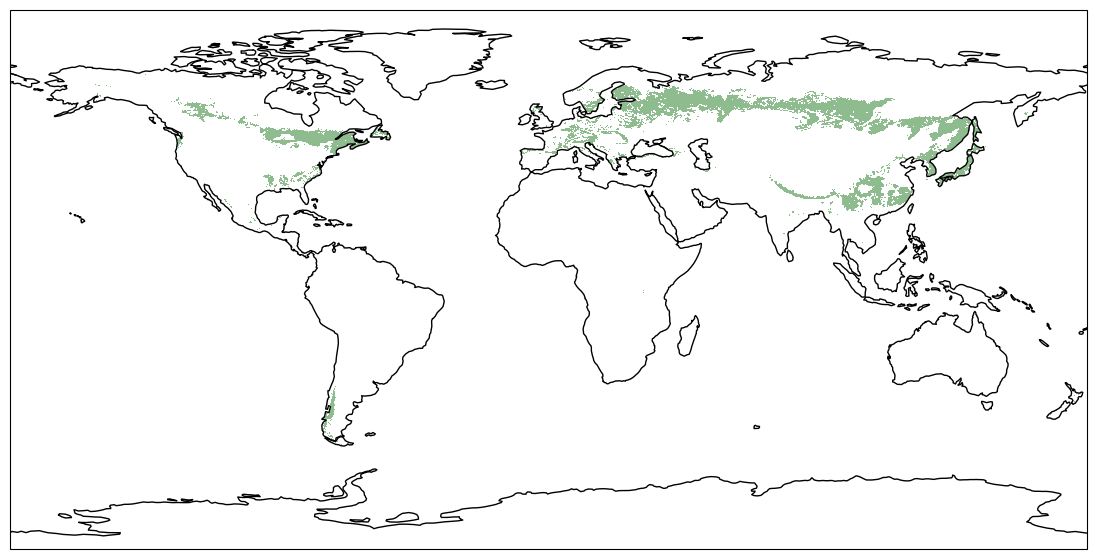

In [39]:
# Repetir el histograma de errores utilizando una clase del IGBP
classid = 5
fig, ax = plt.subplots(1,1, figsize = (14,7), subplot_kw = {"projection": ccrs.PlateCarree(central_longitude= 0)})
igbp_ds.IGBP.where(igbp_ds.IGBP == classid).plot(ax = ax,cmap=plt.cm.colors.ListedColormap(['none', custon_cmap[id2name[classid]]]),  add_colorbar = False)
ax.coastlines("110m")

In [47]:
# Instead of plotting, add IGBP to the windsat dataset, then filter by landcover class
ds["IGBP"] = (("latitude_grid","longitude_grid"), igbp_ds.IGBP.values)

In [53]:
# Select the data in a single class
classid = 3
ds_subset = ds.where(ds.IGBP == classid)

# Drop the added dvar and repeat the validation pipeline.
ds_subset = ds_subset.drop_vars("IGBP")

swath_sd= model_preprocess(ds_subset, swath_sector=swath)
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]
swath_sd = swath_sd[d_vars]

swath_df = swath_sd.to_dataframe().dropna().reset_index("day_number")

day_mapping = doy2month_mapping()

swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")

# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,275.415405,54.125,301.625,258.739990,231.194992,261.077484,243.364990,0.966537,0.869305,0.894020,0.820981
1,281.568542,52.875,295.875,264.779999,252.012497,268.447510,258.479980,0.916312,0.865286,0.923182,0.876916
2,281.038086,52.875,296.125,265.352478,253.539993,268.777496,259.440002,0.927349,0.884180,0.934124,0.897322
3,281.494904,53.125,296.375,267.552490,257.459991,270.552490,262.649994,0.913215,0.859195,0.920100,0.870233
4,281.542419,53.125,296.625,267.732483,257.744995,270.732483,262.877502,0.919122,0.869147,0.925653,0.880332
...,...,...,...,...,...,...,...,...,...,...,...
1025,276.958740,60.875,281.875,205.244995,142.637497,225.830002,177.467499,0.734969,0.508268,0.772840,0.543621
1026,275.558289,60.875,282.125,222.690002,174.212494,237.279999,200.627502,0.782937,0.585876,0.813202,0.619871
1027,275.224548,61.625,280.125,210.824997,152.674988,226.184998,179.212494,0.746259,0.522848,0.814408,0.622321
1028,275.752258,62.125,280.625,217.174988,164.740005,231.327499,190.705002,0.730641,0.495792,0.796620,0.589031


In [54]:
# # Save the original lat lon for plotting later
# lat = combined_df["lat"].copy()
# lon = combined_df["lon"].copy()

# Lat-lon transformations
combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

In [55]:
# Predict for the local sample and plot:
X, y = xy_split(combined_df, y_column = "surtep_ERA5")
combined_df["surtep_MODEL"] = model.predict(X)
combined_df["error"] = combined_df["surtep_ERA5"] - combined_df["surtep_MODEL"]

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


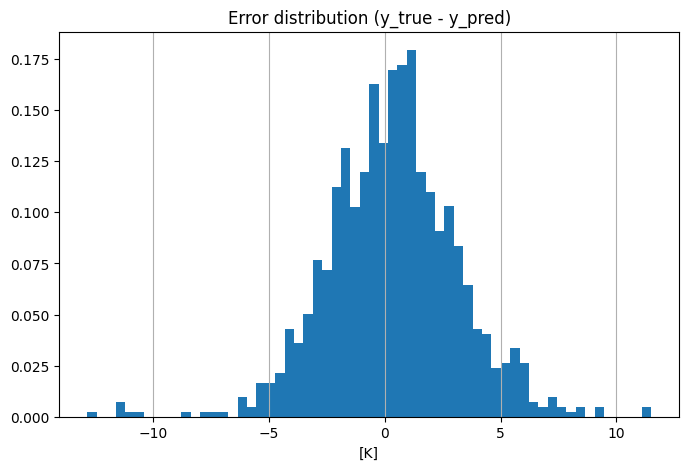

In [56]:
# Error histogram:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = combined_df["error"],
    density = True, bins = 60
)
ax.grid(axis="x")
ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
plt.show()

In [58]:
# Get the mse for the class
from sklearn.metrics import mean_squared_error
class_mse = mean_squared_error(combined_df["surtep_MODEL"], y)
print(class_mse)

8.098552


In [64]:
# Test that the distribution is normal using Shapiro-Wilk
from scipy.stats import shapiro

stat, p = shapiro(combined_df["error"])

print('Shapiro stat:', stat)
print(f'p-value:{p:6.f}')

Shapiro stat: 0.9829934670009984
p-value: 1.3446200890151462e-09


---
Loop for all classes

In [66]:
for classid in id2name.keys():
    # Select the data in a single class
    print(id2name[classid])
    ds_subset = ds.where(ds.IGBP == classid)

    # Drop the added dvar and repeat the validation pipeline.
    ds_subset = ds_subset.drop_vars("IGBP")

    swath_sd= model_preprocess(ds_subset, swath_sector=swath)
    d_vars = [
        "surtep_ERA5",
        "lat",
        "lon",
        "tbtoa_18Ghz_V",
        "tbtoa_18Ghz_H",
        "tbtoa_37Ghz_V",
        "tbtoa_37Ghz_H",
    ]
    swath_sd = swath_sd[d_vars]

    swath_df = swath_sd.to_dataframe().dropna().reset_index("day_number")

    day_mapping = doy2month_mapping()

    swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
    # drop the day_number column
    swath_df = swath_df.drop(columns="day_number")

    # Inner join the telsem df and the ascending df
    combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

    # Drop the month column
    combined_df = combined_df.drop(columns="month")
    
    # Lat-lon transformations
    combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
    combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

    X, y = xy_split(combined_df, y_column = "surtep_ERA5")
    combined_df["surtep_MODEL"] = model.predict(X)
    combined_df["error"] = combined_df["surtep_ERA5"] - combined_df["surtep_MODEL"]


    class_mse = mean_squared_error(combined_df["surtep_MODEL"], y)
    print(f"MSE: {class_mse:.4f}")

    stat, p = shapiro(combined_df["error"])
    print(f'Shapiro stat: {stat:.4f}')
    print(f'p-value:{p:.6f}')
    print("\n")
        

water
